<a href="https://colab.research.google.com/github/SayanDas07/KWS-using-FewShotLearning/blob/main/CNNKWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi


Tue Jun 10 16:43:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p data_10_wav/data

In [4]:
!wget -O speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2025-06-10 16:43:42--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.170.207, 74.125.200.207, 74.125.130.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.170.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  23.4MB/s    in 1m 43s  

2025-06-10 16:45:26 (22.5 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [5]:
!tar -xzf speech_commands_v0.02.tar.gz -C data_10_wav/data

In [16]:
DATASET_PATH = "data_10_wav/data/"
save_path = "/content/drive/MyDrive/NITDGP"

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import librosa

In [17]:
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

In [18]:
SAMPLES_TO_CONSIDER = 16000

In [19]:
frame_length = int(SAMPLES_TO_CONSIDER * (32 / 1000))
hop_length = int(SAMPLES_TO_CONSIDER * (16 / 1000))

In [20]:
print("frame_length:", frame_length)
print("hop_length:", hop_length)

frame_length: 512
hop_length: 256


In [21]:
keyword_list = ['off', 'left', 'down', 'up', 'go', 'on', 'stop', 'unknown', 'right', 'yes']
keyword_index_dict = {k: i for i, k in enumerate(keyword_list)}
print("Keyword Index Mapping:", keyword_index_dict)

Keyword Index Mapping: {'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5, 'stop': 6, 'unknown': 7, 'right': 8, 'yes': 9}


In [22]:
def hamming_window(length):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(length) / (length - 1))

In [23]:
labels = []
log_mel_spectrograms = []

In [24]:
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    if dirpath != DATASET_PATH:
        label = os.path.basename(dirpath)

        final_label = label if label in keyword_list else 'unknown'

        print(f"\nProcessing: '{label}' as '{final_label}'")
        count = 0

        filenames.sort()

        for f in filenames:
            file_path = os.path.join(dirpath, f)
            try:
                signal, sample_rate = librosa.load(file_path, sr=16000)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue

            if len(signal) >= SAMPLES_TO_CONSIDER:
                signal = signal[:SAMPLES_TO_CONSIDER]
            else:
                signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

            signal = signal.astype(np.float32)
            windowed_signal = signal * hamming_window(SAMPLES_TO_CONSIDER)

            mel_spec = librosa.feature.melspectrogram(
                y=windowed_signal,
                sr=16000,
                n_mels=40,
                n_fft=frame_length,
                win_length=frame_length,
                hop_length=hop_length,
                center=False
            )

            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            log_mel_spectrograms.append(log_mel_spec.T)
            labels.append(keyword_index_dict[final_label])

            count += 1
            if count >= 3000:
                print(f"{final_label} : {keyword_index_dict[final_label]} = {count}")
                print(log_mel_spec.T.shape)
                break



Processing: 'two' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'cat' as 'unknown'

Processing: 'backward' as 'unknown'

Processing: 'nine' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'sheila' as 'unknown'

Processing: 'four' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'visual' as 'unknown'

Processing: 'three' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'seven' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: '_background_noise_' as 'unknown'
Error loading file data_10_wav/data/_background_noise_/README.md: 

Processing: 'tree' as 'unknown'


<ipython-input-24-1445883842>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



Processing: 'on' as 'on'
on : 5 = 3000
(61, 40)

Processing: 'wow' as 'unknown'

Processing: 'follow' as 'unknown'

Processing: 'left' as 'left'
left : 1 = 3000
(61, 40)

Processing: 'one' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'five' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'stop' as 'stop'
stop : 6 = 3000
(61, 40)

Processing: 'go' as 'go'
go : 4 = 3000
(61, 40)

Processing: 'learn' as 'unknown'

Processing: 'dog' as 'unknown'

Processing: 'happy' as 'unknown'

Processing: 'no' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'forward' as 'unknown'

Processing: 'eight' as 'unknown'
unknown : 7 = 3000
(61, 40)

Processing: 'bird' as 'unknown'

Processing: 'down' as 'down'
down : 2 = 3000
(61, 40)

Processing: 'off' as 'off'
off : 0 = 3000
(61, 40)

Processing: 'marvin' as 'unknown'

Processing: 'right' as 'right'
right : 8 = 3000
(61, 40)

Processing: 'up' as 'up'
up : 3 = 3000
(61, 40)

Processing: 'house' as 'unknown'

Processing: 'yes' as 'yes'
yes

In [46]:
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
def plot_mel_spectrogram(spec, label_idx):
    plt.figure(figsize=(6, 4))
    plt.imshow(spec.T, aspect='auto', origin='lower')
    plt.title(f"Label: {keyword_list[label_idx]}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


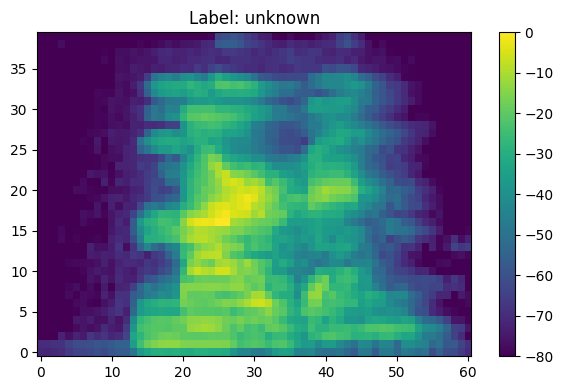

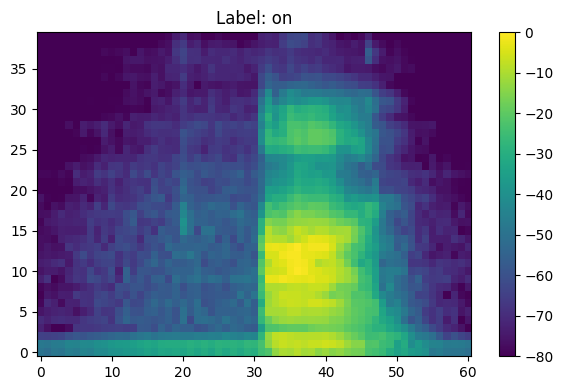

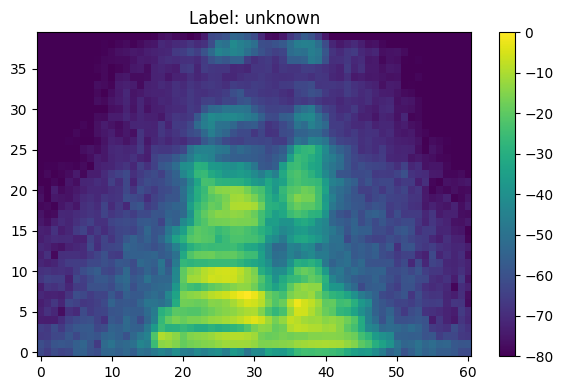

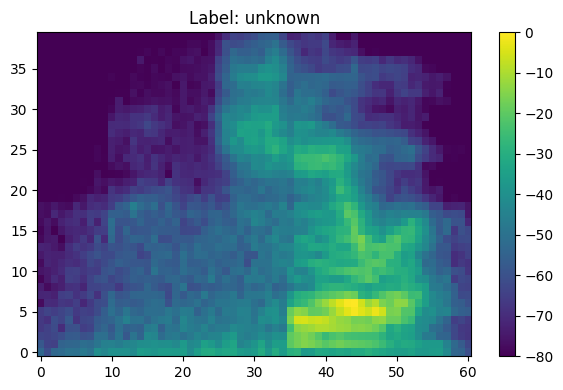

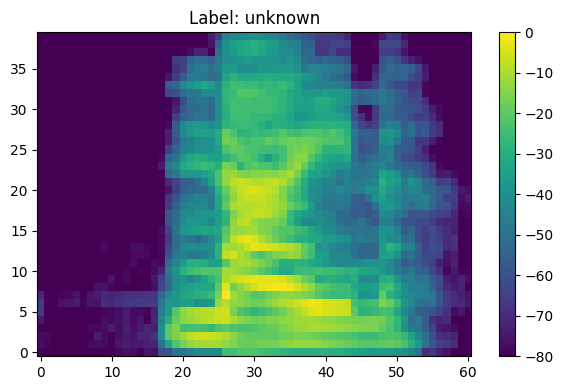

In [ ]:
import random

for _ in range(5):
    idx = random.randint(0, len(log_mel_spectrograms) - 1)
    plot_mel_spectrogram(log_mel_spectrograms[idx], labels[idx])


In [25]:
np.save(os.path.join(save_path, 'X_log_mel_spectrograms.npy'), np.array(log_mel_spectrograms))
np.save(os.path.join(save_path, 'y_log_mel_spectrograms.npy'), np.array(labels))
print("Feature extraction done and saved.")


Feature extraction done and saved.


In [26]:
X = np.load(os.path.join(save_path, 'X_log_mel_spectrograms.npy'))
y = np.load(os.path.join(save_path, 'y_log_mel_spectrograms.npy'))

In [27]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)



X shape: (88381, 61, 40)
y shape: (88381,)


In [28]:
# Normalize
X = X / np.max(np.abs(X))

# ✅ Remove extra dims and reshape correctly
X = np.squeeze(X)  # removes all dimensions of size 1, if any
if X.ndim == 3:
    X = X[..., np.newaxis]  # adds only (61, 40, 1) as required
CLASSES = len(keyword_list)
y_cat = to_categorical(y, CLASSES)

In [29]:
from collections import Counter
label_map = { 'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5,
              'stop': 6, 'unknown': 7, 'right': 8, 'yes': 9 }

# Invert the label map to get index → label
inv_label_map = {v: k for k, v in label_map.items()}

# Count samples per label
label_counts = Counter(y)

# Display sample count for each label
for label_idx in sorted(label_counts):
    label_name = inv_label_map.get(label_idx, 'unknown')
    print(f"{label_name}: {label_counts[label_idx]} samples")

off: 3000 samples
left: 3000 samples
down: 3000 samples
up: 3000 samples
go: 3000 samples
on: 3000 samples
stop: 3000 samples
unknown: 61381 samples
right: 3000 samples
yes: 3000 samples


In [31]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)

X shape: (88381, 61, 40, 1)
y shape: (88381,)


In [32]:

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

In [33]:
def build_model(hparams):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    filters = hparams['filters']
    kernel_size = hparams['kernel_size']
    use_bn = hparams['use_bn']
    num_res_blocks = hparams['residual_blocks']
    num_fc_layers = hparams['fc_layers']
    use_dropout = hparams['use_dropout']

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters, kernel_size, padding='same')(inputs)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    for block_idx in range(num_res_blocks):
        skip = layers.Conv2D(filters * 2, (1,1), strides=(2,2), padding='same')(x)
        y = layers.Conv2D(filters * 2, kernel_size, padding='same')(x)
        if use_bn:
            y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.Conv2D(filters * 2, kernel_size, padding='same')(y)
        if use_bn:
            y = layers.BatchNormalization()(y)
        y = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(y)
        x = layers.add([y, skip])
        x = layers.ReLU()(x)
        filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    fc_config = {
        1: [64],
        2: [128, 64],
        3: [256, 128, 64],
        4: [512, 256, 128, 64]
    }

    for i, units in enumerate(fc_config[num_fc_layers]):
        x = layers.Dense(units, activation='relu')(x)
        if use_dropout:
            x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(CLASSES, activation='softmax')(x)
    return Model(inputs, outputs)

In [34]:
hparams = {
    'filters': 32,
    'kernel_size': 5,
    'use_bn': False,
    'residual_blocks': 1,
    'fc_layers': 4,
    'use_dropout': True
}

In [35]:
model = build_model(hparams)

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 61, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 61, 40,    │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 61, 40,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 40,    │     25,632 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 20,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 20,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 31, 20,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 20,    │    102,464 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 10,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 10,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 10,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 10,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_3[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     33,280 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]   

 Total params: 388,714 (1.48 MB)

 Trainable params: 388,714 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (70704, 61, 40, 1)
y_train: (70704, 10)
X_test: (17677, 61, 40, 1)
y_test: (17677, 10)


In [39]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.6920 - loss: 1.2957 - val_accuracy: 0.7661 - val_loss: 0.6623
Epoch 2/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.8132 - loss: 0.5776 - val_accuracy: 0.9340 - val_loss: 0.2269
Epoch 3/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9243 - loss: 0.2640 - val_accuracy: 0.9408 - val_loss: 0.2012
Epoch 4/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9415 - loss: 0.2064 - val_accuracy: 0.9394 - val_loss: 0.1993
Epoch 5/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9504 - loss: 0.1745 - val_accuracy: 0.9567 - val_loss: 0.1422
Epoch 6/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9569 - loss: 0.1503 - val_accuracy: 0.9578 - val_loss: 0.1500
Epoch 7/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9598 - loss: 0.1403 - val_accuracy: 0.9523 - val_loss: 0.1579
Epoch 8/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9641 -

In [40]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9660 - loss: 0.1268

Test Accuracy: 96.58%


In [41]:
y_pred = model.predict(X_test)

553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [42]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [43]:
y_true_classes = np.argmax(y_test, axis=1)


In [44]:
print(classification_report(y_true_classes, y_pred_classes, target_names=keyword_list))

              precision    recall  f1-score   support

         off       0.92      0.94      0.93       600
        left       0.98      0.89      0.93       600
        down       0.95      0.88      0.92       600
          up       0.96      0.90      0.93       600
          go       0.88      0.94      0.90       600
          on       0.95      0.91      0.93       600
        stop       0.99      0.93      0.96       600
     unknown       0.97      0.99      0.98     12277
       right       0.99      0.92      0.95       600
         yes       0.99      0.95      0.97       600

    accuracy                           0.97     17677
   macro avg       0.96      0.92      0.94     17677
weighted avg       0.97      0.97      0.97     17677



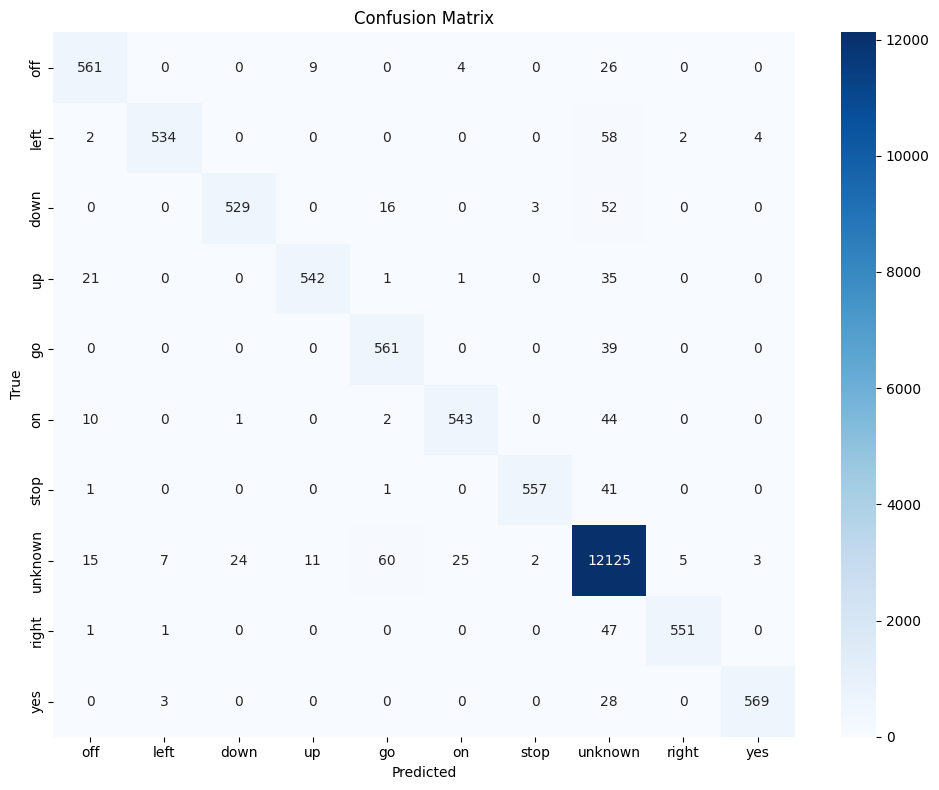

In [48]:
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=keyword_list, yticklabels=keyword_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [49]:
model.save(os.path.join(save_path, 'my_keyword_spotting_model11.h5'))